This is meant to be a toy network coupled with a very simple text processing pipeline.

Begin

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False

In [2]:
# pandas and numpy for dataframes and array manipulations
# tqdm as a progress
# matplotlib for plotting

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

# usual PyTorch imports for tensor manipulations, neural networks and data processings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# import some sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# import keras tokenizing utilities 
from keras.preprocessing import text, sequence

# import tensorboardX in case we want to log metrics to tensorboard (requires tensorflow installed - optional)
from tensorboardX import SummaryWriter

from graphviz import Digraph
from torchviz import make_dot

Using TensorFlow backend.


In [3]:
# we load train and test data and separate the target in another variable

X_train = pd.read_csv('./data/train.csv')
X_test = pd.read_csv('./data/test.csv')
Y = X_train['target'].values

In [4]:
# we define some keras tokenization parameters
# NUM_WORDS: the maximum number of tokens the tokenizer should keep (based on frequency). The rest is ignored
# MAX_LEN is the maximum length we set to all documents after being tokenized
# is len(sequence) < MAX_LEN: keras tokenizer pads to the MAX_LEN with 0 values
# is len(sequence) > MAX_LEN: keras tokenizer truncates to MAX_LEN

NUM_WORDS = 100000
MAX_LEN = 25

In [5]:
# initialize the tokenizer
tokenizer = text.Tokenizer(num_words=NUM_WORDS)

# fits it on train data
tokenizer.fit_on_texts(tqdm_notebook(X_train['question_text'], leave=False))

# use it to transform both train and test data
train_sequences = tokenizer.texts_to_sequences(tqdm_notebook(X_train['question_text'], leave=False))
test_sequences = tokenizer.texts_to_sequences(tqdm_notebook(X_test['question_text'], leave=False))

# pad to MAX_LEN
train_sequences_padded = sequence.pad_sequences(tqdm_notebook(train_sequences, leave=False), maxlen=MAX_LEN)
test_sequences_padded = sequence.pad_sequences(tqdm_notebook(test_sequences, leave=False), maxlen=MAX_LEN)

Here is the train output:

In [6]:
train_sequences_padded[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     9,    48,  6683,  7219,   158,    55,
         6107,    36,     4,  1206,     6,     1,  8333],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
           11,    14,    24,    29,  3864,   498,     9,    35,    14,
         3672,    37,     5,  3089,    10,    44,  1846],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    16,    26,  2002,
          374,    70,    26,  2002,   374,   451,  5546],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     9,    48,
        13005,  8284, 52192,   119,     1, 39877, 28269],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    15,     8,  1130, 42987, 99430,   911,     5,     4,
         3133,  1533,    46,    96,  1465,     1,  9340]],

With the corresponding shape

In [7]:
train_sequences_padded.shape

(1306122, 25)

Same with the test output

In [8]:
test_sequences_padded.shape

(375806, 25)

Now we define the model architecture that will ingest this data.

We'll keep it simple:

- an embedding layer: basically a look-up table that converts each token in the dictionary to a vector with dense representation that will be learn and adjusted throughout training

- two concatenated pooling layers with max and mean operations

- a fully connected layer

In [9]:
# we initialize the PyTorch model as a subclass of nn.Module
class Model(nn.Module):
    def __init__(self, embedding_dim):
        super(Model, self).__init__()
        
        # we define the embedding layer with a size equal to NUM_WORDS and an embedding dimension
        # defined as a parameter in the constructor
        self.embedding_layer = nn.Embedding(NUM_WORDS, embedding_dim)
        self.embedding_layer.weight.requires_grad = True
        
        # we define a linear layer with an input size of MAX_LEN * 2 (because of the concatenation of two 
        # pooling operations)
        self.fc1 = nn.Linear(MAX_LEN * 2, 1)
        
    def forward(self, inputs):
        # inputs shape : (batch_size, MAX_LEN)
        
        embedded_inputs = self.embedding_layer(inputs)
        # embedded_inputs shape : (batch_size, MAX_LEN, embedding_dim)
        
        avg_pooled_inputs = torch.mean(embedded_inputs, -1)
        # avg_pooled_inputs shape : (batch_size, MAX_LEN)
        
        max_pooled_inputs = torch.max(embedded_inputs, -1)[0]
        # max_pooled_inputs shape : (batch_size, MAX_LEN)
        
        concat_pooled_layers = torch.cat([avg_pooled_inputs, max_pooled_inputs], -1)
        # concat_pooled_layers shape : (batch_size, 2 * MAX_LEN)
        
        outputs = self.fc1(concat_pooled_layers)
        # outputs shape : (batch_size, 1)
        return outputs

Now we define a custom Dataset to load data very efficiently

In [10]:
class MyDataset(Dataset):
    # it takes two parameters in the constructor
    # padded_sequencs: the sequences previously processed with padding
    # labels: the corresponding targets
    def __init__(self, padded_sequences, labels):
        self.padded_sequences = padded_sequences
        self.labels = labels
    
    
    # special method to return the length of the dataset
    def __len__(self):
        return len(self.padded_sequences)
    
    # special method to get any given item at a given index while applying some preprocessings on it
    def __getitem__(self, index):
        # get a padded sequence
        x = self.padded_sequences[index, :]
        
        # convert it to long tensor (because the values are actually indexes of mapping)
        x = torch.LongTensor(x)  
        
        # convert the target to a float tensor
        y = self.labels[index]
        y = torch.Tensor([y])
        return x, y

I define two functions I usually use in the main training loop:

- compute_f1_score: takes a input y: the batch of labels, preds: the corresponding outputs of the models and computes the f1_score

- print_metrics: prints at any given iteration, the current average loss and f1 score

In [11]:
def compute_f1_score(y, preds, th=0.5):
    y_preds_proba = torch.sigmoid(preds)
    y_preds_proba = y_preds_proba.cpu().detach().numpy()
    y_pred = (y_preds_proba > th).astype(int)
    
    y_true = y.detach().cpu().numpy()
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    return f1

def print_metrics(iteration, total_iterations, epoch, total_epochs, loss_list, f1_list, print_every, train=True):
    if train:
        msg = f'Epoch: {epoch+1} / {total_epochs} |Iteration: {iteration} / {total_iterations} \n'
        msg += f'Average train loss: {np.mean(loss_list)} | Average train f1: {np.mean(f1_list)}'
        
    else:
        msg = f'Epoch: {epoch+1} / {total_epochs} |Iteration: {iteration} / {total_iterations} \n'
        msg += f'Average val loss: {np.mean(loss_list)} | Average val f1: {np.mean(f1_list)}'
        
    if iteration % print_every == 0:
        print(msg)

Now we prepare a train and validation splits to train the model and consequently evaluate it

In [12]:
x_train, x_val, y_train, y_val = train_test_split(train_sequences_padded, Y, test_size=0.2, random_state=42)

Now we can create a train dataset and validation dataset

In [13]:
train_dataset = MyDataset(x_train, y_train)
val_dataset = MyDataset(x_val, y_val)

These two objects will allow us to create train and validation dataloader.

Dataloaders are PyTorch objects that allow to load data efficiently. They handle batching, parallelizing over CPUs, and data augmentation among other things. 

We'll use a batch size of 256 and initialize the train and val loaders over 5 workers

In [14]:
batch_size = 256

train_loader = DataLoader(train_dataset, num_workers=5, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=5, batch_size=batch_size)

Now we initialize the model and move it to the GPU for acceleration.

We define the optimizer: Adam with learning rate : 0.003

We define the loss: Binary Cross Entropy that i.e BCEWithLogitsLoss

In [15]:
model = Model(300)

model = model.cuda()

optimizer = torch.optim.Adam(lr=0.003, params=model.parameters())
criterion = nn.BCEWithLogitsLoss()

Here's the main training/evaluation process that loops over a given number of epochs.

At each epoch, two loops:

- a training loop over the train_loader: here the model is set to train mode. gradients are computed and weights are updated over each batch

- a validation (evaluation) loop over the val_loader: here the model is set eval mode. we only compute predictions

In [16]:
num_epochs = 5
print_every_train = 500
print_every_val = 150


for epoch in tqdm_notebook(range(num_epochs)):
    
    # train model
    
    f1_scores_train = []
    losses_train = []

    model.train()
    for i, (x, y) in enumerate(tqdm_notebook(train_loader, leave=False, total=len(train_loader))):
        
        # pass batches to GPU
        x = x.cuda()
        y = y.cuda()
        
        # clear gradients
        optimizer.zero_grad()
        
        # compute predictions: forward pass on the batch
        preds = model.forward(x)
        
        # compute the loss on the batch
        loss = criterion(preds, y)
        
        # compute the gardients by derivating the loss
        loss.backward()
        
        # update the weights
        optimizer.step()
        
        # keep track of losses and f1 scores for each epoch
        losses_train.append(loss.item())
        
        f1_score_train = compute_f1_score(y, preds)
        f1_scores_train.append(f1_score_train)
        
        # print metrics
        print_metrics(i, len(train_loader), epoch, num_epochs, losses_train, f1_scores_train, print_every_train)
        
    # evaluation mode
        
    f1_scores_val = []
    losses_val = []
    
    model.eval()
    for i, (x, y) in enumerate(tqdm_notebook(val_loader, leave=False, total=len(val_loader))):
        
        # pass batches to GPU
        x = x.cuda()
        y = y.cuda()
        
        # make predictions
        preds = model.forward(x)
        
        # computes the losses and f1 scores
        loss = criterion(y, preds)
        losses_val.append(loss.item())
        
        f1_score_val = compute_f1_score(y, preds)
        f1_scores_val.append(f1_score_val)
        
        # print metrics
        print_metrics(i, len(train_loader), epoch, num_epochs, losses_val, f1_scores_val, print_every_val, train=False)

Epoch: 1 / 5 |Iteration: 0 / 4082 
Average train loss: 0.6260775327682495 | Average train f1: 0.19999999999999998


/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1 / 5 |Iteration: 500 / 4082 
Average train loss: 0.18710285529286086 | Average train f1: 0.11252626989612288
Epoch: 1 / 5 |Iteration: 1000 / 4082 
Average train loss: 0.16348664072173816 | Average train f1: 0.25080317049367945
Epoch: 1 / 5 |Iteration: 1500 / 4082 
Average train loss: 0.1533402460692407 | Average train f1: 0.31649104428495867
Epoch: 1 / 5 |Iteration: 2000 / 4082 
Average train loss: 0.14781327426865482 | Average train f1: 0.35293284083906173
Epoch: 1 / 5 |Iteration: 2500 / 4082 
Average train loss: 0.14394471271247303 | Average train f1: 0.38073687487435737
Epoch: 1 / 5 |Iteration: 3000 / 4082 
Average train loss: 0.1410980424652871 | Average train f1: 0.39870099247460805
Epoch: 1 / 5 |Iteration: 3500 / 4082 
Average train loss: 0.1390492692611041 | Average train f1: 0.41269331637219087
Epoch: 1 / 5 |Iteration: 4000 / 4082 
Average train loss: 0.13719365658446628 | Average train f1: 0.4246962444553369


Epoch: 1 / 5 |Iteration: 0 / 4082 
Average val loss: 0.739369809627533 | Average val f1: 0.6250000000000001
Epoch: 1 / 5 |Iteration: 150 / 4082 
Average val loss: 0.7453723995890839 | Average val f1: 0.5147815091293765
Epoch: 1 / 5 |Iteration: 300 / 4082 
Average val loss: 0.7466469080345179 | Average val f1: 0.5173881524695083
Epoch: 1 / 5 |Iteration: 450 / 4082 
Average val loss: 0.7491616993944291 | Average val f1: 0.5149335667633373
Epoch: 1 / 5 |Iteration: 600 / 4082 
Average val loss: 0.7481068153547963 | Average val f1: 0.5139121578789464
Epoch: 1 / 5 |Iteration: 750 / 4082 
Average val loss: 0.7482267748341261 | Average val f1: 0.5134132743818568
Epoch: 1 / 5 |Iteration: 900 / 4082 
Average val loss: 0.7487260522641299 | Average val f1: 0.51291953515809


Epoch: 2 / 5 |Iteration: 0 / 4082 
Average train loss: 0.1028328612446785 | Average train f1: 0.56
Epoch: 2 / 5 |Iteration: 500 / 4082 
Average train loss: 0.11273196277147282 | Average train f1: 0.5472655538915973
Epoch: 2 / 5 |Iteration: 1000 / 4082 
Average train loss: 0.11371267822893945 | Average train f1: 0.5515320923847151
Epoch: 2 / 5 |Iteration: 1500 / 4082 
Average train loss: 0.11365482674478532 | Average train f1: 0.5494643290394827
Epoch: 2 / 5 |Iteration: 2000 / 4082 
Average train loss: 0.11458761862542914 | Average train f1: 0.5459451937111124
Epoch: 2 / 5 |Iteration: 2500 / 4082 
Average train loss: 0.11500660484818305 | Average train f1: 0.5447619655614699
Epoch: 2 / 5 |Iteration: 3000 / 4082 
Average train loss: 0.11511111479551742 | Average train f1: 0.5460802078332058
Epoch: 2 / 5 |Iteration: 3500 / 4082 
Average train loss: 0.11545876390493554 | Average train f1: 0.5457131167295066
Epoch: 2 / 5 |Iteration: 4000 / 4082 
Average train loss: 0.11567545604352741 | Ave

Epoch: 2 / 5 |Iteration: 0 / 4082 
Average val loss: 0.7291238903999329 | Average val f1: 0.6250000000000001
Epoch: 2 / 5 |Iteration: 150 / 4082 
Average val loss: 0.7428735668296056 | Average val f1: 0.5234909905283907
Epoch: 2 / 5 |Iteration: 300 / 4082 
Average val loss: 0.7441046293391738 | Average val f1: 0.5270866990663704
Epoch: 2 / 5 |Iteration: 450 / 4082 
Average val loss: 0.7467111035884088 | Average val f1: 0.5230776290282568
Epoch: 2 / 5 |Iteration: 600 / 4082 
Average val loss: 0.7455885829822394 | Average val f1: 0.5249078370463824
Epoch: 2 / 5 |Iteration: 750 / 4082 
Average val loss: 0.7457338054075381 | Average val f1: 0.5225577525221332
Epoch: 2 / 5 |Iteration: 900 / 4082 
Average val loss: 0.7459265944960379 | Average val f1: 0.5249203592896137


Epoch: 3 / 5 |Iteration: 0 / 4082 
Average train loss: 0.11115862429141998 | Average train f1: 0.5925925925925927
Epoch: 3 / 5 |Iteration: 500 / 4082 
Average train loss: 0.10916512768842027 | Average train f1: 0.5760886305732152
Epoch: 3 / 5 |Iteration: 1000 / 4082 
Average train loss: 0.10888447286886768 | Average train f1: 0.5819613688319033
Epoch: 3 / 5 |Iteration: 1500 / 4082 
Average train loss: 0.10890877820913748 | Average train f1: 0.5829059285371334
Epoch: 3 / 5 |Iteration: 2000 / 4082 
Average train loss: 0.10935459069829473 | Average train f1: 0.5813547658701198
Epoch: 3 / 5 |Iteration: 2500 / 4082 
Average train loss: 0.10945945630957488 | Average train f1: 0.5790436524633925
Epoch: 3 / 5 |Iteration: 3000 / 4082 
Average train loss: 0.10955759509404832 | Average train f1: 0.578526264393114
Epoch: 3 / 5 |Iteration: 3500 / 4082 
Average train loss: 0.1095404271999365 | Average train f1: 0.5779114034184927
Epoch: 3 / 5 |Iteration: 4000 / 4082 
Average train loss: 0.1097262633

Epoch: 3 / 5 |Iteration: 0 / 4082 
Average val loss: 0.7061707377433777 | Average val f1: 0.7058823529411765
Epoch: 3 / 5 |Iteration: 150 / 4082 
Average val loss: 0.7251459896959216 | Average val f1: 0.5457804876915987
Epoch: 3 / 5 |Iteration: 300 / 4082 
Average val loss: 0.726689200068629 | Average val f1: 0.5505327782095749
Epoch: 3 / 5 |Iteration: 450 / 4082 
Average val loss: 0.7294037320925761 | Average val f1: 0.548843354054185
Epoch: 3 / 5 |Iteration: 600 / 4082 
Average val loss: 0.7285346065503785 | Average val f1: 0.5509294184803266
Epoch: 3 / 5 |Iteration: 750 / 4082 
Average val loss: 0.7283126215007747 | Average val f1: 0.550755198665633
Epoch: 3 / 5 |Iteration: 900 / 4082 
Average val loss: 0.7284937068968846 | Average val f1: 0.5526674498587693


Epoch: 4 / 5 |Iteration: 0 / 4082 
Average train loss: 0.1076628789305687 | Average train f1: 0.4166666666666667
Epoch: 4 / 5 |Iteration: 500 / 4082 
Average train loss: 0.1029508417684161 | Average train f1: 0.6052959085948069
Epoch: 4 / 5 |Iteration: 1000 / 4082 
Average train loss: 0.10444203830444133 | Average train f1: 0.6075418267922074
Epoch: 4 / 5 |Iteration: 1500 / 4082 
Average train loss: 0.10423376523876571 | Average train f1: 0.605609909622825
Epoch: 4 / 5 |Iteration: 2000 / 4082 
Average train loss: 0.10425597729570028 | Average train f1: 0.604470553690709
Epoch: 4 / 5 |Iteration: 2500 / 4082 
Average train loss: 0.10442806529503067 | Average train f1: 0.602266636477872
Epoch: 4 / 5 |Iteration: 3000 / 4082 
Average train loss: 0.10489600399798928 | Average train f1: 0.600860300538997
Epoch: 4 / 5 |Iteration: 3500 / 4082 
Average train loss: 0.10551977866259822 | Average train f1: 0.5996134449719115
Epoch: 4 / 5 |Iteration: 4000 / 4082 
Average train loss: 0.10584830109219

Epoch: 4 / 5 |Iteration: 0 / 4082 
Average val loss: 0.7209623456001282 | Average val f1: 0.6
Epoch: 4 / 5 |Iteration: 150 / 4082 
Average val loss: 0.7380385651493704 | Average val f1: 0.5229428677971403
Epoch: 4 / 5 |Iteration: 300 / 4082 
Average val loss: 0.7392194912679172 | Average val f1: 0.5320281943140253
Epoch: 4 / 5 |Iteration: 450 / 4082 
Average val loss: 0.7423648987535363 | Average val f1: 0.5272940449358879
Epoch: 4 / 5 |Iteration: 600 / 4082 
Average val loss: 0.7413579248350591 | Average val f1: 0.5310152188627079
Epoch: 4 / 5 |Iteration: 750 / 4082 
Average val loss: 0.7413006431253233 | Average val f1: 0.5302632941617091
Epoch: 4 / 5 |Iteration: 900 / 4082 
Average val loss: 0.7414083823512053 | Average val f1: 0.5322610179114294


Epoch: 5 / 5 |Iteration: 0 / 4082 
Average train loss: 0.10147333890199661 | Average train f1: 0.5925925925925927
Epoch: 5 / 5 |Iteration: 500 / 4082 
Average train loss: 0.09903993588424252 | Average train f1: 0.6277760015321595
Epoch: 5 / 5 |Iteration: 1000 / 4082 
Average train loss: 0.09934390951822569 | Average train f1: 0.6221800394442988
Epoch: 5 / 5 |Iteration: 1500 / 4082 
Average train loss: 0.10024081324435011 | Average train f1: 0.6194852238432089
Epoch: 5 / 5 |Iteration: 2000 / 4082 
Average train loss: 0.10065948530689053 | Average train f1: 0.6205277291056779
Epoch: 5 / 5 |Iteration: 2500 / 4082 
Average train loss: 0.10144812276498263 | Average train f1: 0.6173487911205533
Epoch: 5 / 5 |Iteration: 3000 / 4082 
Average train loss: 0.10207413128145493 | Average train f1: 0.615753287589061
Epoch: 5 / 5 |Iteration: 3500 / 4082 
Average train loss: 0.10238519173474081 | Average train f1: 0.6142481513191413
Epoch: 5 / 5 |Iteration: 4000 / 4082 
Average train loss: 0.102756856

Epoch: 5 / 5 |Iteration: 0 / 4082 
Average val loss: 0.7062171697616577 | Average val f1: 0.7222222222222222
Epoch: 5 / 5 |Iteration: 150 / 4082 
Average val loss: 0.7288045555550531 | Average val f1: 0.5444146144199118
Epoch: 5 / 5 |Iteration: 300 / 4082 
Average val loss: 0.7302469365620534 | Average val f1: 0.5494088447691461
Epoch: 5 / 5 |Iteration: 450 / 4082 
Average val loss: 0.7332742641083153 | Average val f1: 0.5436537338174602
Epoch: 5 / 5 |Iteration: 600 / 4082 
Average val loss: 0.7321674872357119 | Average val f1: 0.5461457383544558
Epoch: 5 / 5 |Iteration: 750 / 4082 
Average val loss: 0.7319254773593298 | Average val f1: 0.5448036607959894
Epoch: 5 / 5 |Iteration: 900 / 4082 
Average val loss: 0.7319583415191261 | Average val f1: 0.5467584581568314



End.

In [17]:
inputs = train_sequences_padded[:1]
inputs = torch.LongTensor(inputs).cuda()

outputs = model(inputs)

In [18]:
graph = make_dot(outputs, params=dict(model.named_parameters()))

Visualization of the model architecture

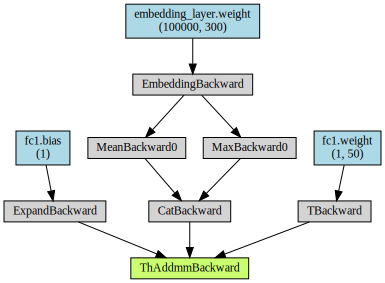

In [19]:
graph